In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

In [2]:
from transformers import TFViTModel, ViTConfig

c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri"

if os.path.exists(data_dir):
    print("✅ Path exists:", data_dir)
    print("Subdirectories:", os.listdir(data_dir))
else:
    print("❌ Path not found!")

✅ Path exists: C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri
Subdirectories: ['test', 'train', 'val']


In [4]:
import os

data_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri"

splits = ["train", "validation", "test"]

for split in splits:
    split_path = os.path.join(data_dir, split)
    if not os.path.exists(split_path):
        print(f"\n⚠️ {split.upper()} folder not found!")
        continue

    print(f"\n📂 {split.upper()} set:")

    for patient in os.listdir(split_path):
        patient_path = os.path.join(split_path, patient)
        if not os.path.isdir(patient_path):
            continue

        originals = [
            f for f in os.listdir(patient_path)
            if f.lower().endswith(('.tif', '.tiff')) and not f.lower().endswith('_mask.tif')
        ]
        masks = [
            f for f in os.listdir(patient_path)
            if f.lower().endswith(('_mask.tif', '_mask.tiff'))
        ]

        print(f"  🧑 Patient {patient}: {len(originals)} originals | {len(masks)} masks")



📂 TRAIN set:
  🧑 Patient Original: 0 originals | 0 masks
  🧑 Patient Segmented: 0 originals | 0 masks
  🧑 Patient TCGA_CS_4941_19960909: 23 originals | 23 masks
  🧑 Patient TCGA_CS_4944_20010208: 20 originals | 20 masks
  🧑 Patient TCGA_CS_5393_19990606: 20 originals | 20 masks
  🧑 Patient TCGA_CS_5395_19981004: 20 originals | 20 masks
  🧑 Patient TCGA_CS_5396_20010302: 24 originals | 24 masks
  🧑 Patient TCGA_CS_5397_20010315: 22 originals | 22 masks
  🧑 Patient TCGA_CS_6186_20000601: 25 originals | 25 masks
  🧑 Patient TCGA_CS_6188_20010812: 24 originals | 24 masks
  🧑 Patient TCGA_CS_6290_20000917: 20 originals | 20 masks
  🧑 Patient TCGA_CS_6665_20010817: 24 originals | 24 masks
  🧑 Patient TCGA_CS_6666_20011109: 26 originals | 26 masks
  🧑 Patient TCGA_CS_6667_20011105: 20 originals | 20 masks
  🧑 Patient TCGA_CS_6669_20020102: 22 originals | 22 masks
  🧑 Patient TCGA_DU_5849_19950405: 38 originals | 38 masks
  🧑 Patient TCGA_DU_5851_19950428: 40 originals | 40 masks
  🧑 Patient 

In [5]:
import os

data_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri"

splits = ["train", "val", "test"]

counts = {}


for split in splits:
    split_path = os.path.join(data_dir, split)
    if not os.path.exists(split_path):
        print(f"⚠️ {split.upper()} folder not found!")
        continue

    counts[split] = {}

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path):
            continue

        num_images = len([
            f for f in os.listdir(cls_path)
            if f.lower().endswith(('.tif', '.tiff')) and not f.lower().endswith('_mask.tif')
        ])

        counts[split][cls] = num_images

split_totals = {split: sum(class_counts.values()) for split, class_counts in counts.items()}
grand_total = sum(split_totals.values())

for split, total in split_totals.items():
    print(f"{split.capitalize()} total: {total} images")

print(f"\n📊 Grand Total: {grand_total} images")


Train total: 2760 images
Val total: 646 images
Test total: 523 images

📊 Grand Total: 3929 images


In [6]:
import os

data_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri"
splits = ["train", "val", "test"]

counts_all = {}

for split in splits:
    split_path = os.path.join(data_dir, split)
    if not os.path.exists(split_path):
        print(f"⚠️ {split.upper()} folder not found!")
        continue

    counts_all[split] = {}

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path):
            continue

        # Count ALL .tif/.tiff files (originals + masks)
        num_images = len([
            f for f in os.listdir(cls_path)
            if f.lower().endswith(('.tif', '.tiff'))
        ])

        counts_all[split][cls] = num_images

split_totals_all = {split: sum(class_counts.values()) for split, class_counts in counts_all.items()}
grand_total_all = sum(split_totals_all.values())

for split, total in split_totals_all.items():
    print(f"{split.capitalize()} total: {total} images (including masks)")

print(f"\n📊 Grand Total (including masks): {grand_total_all} images")

Train total: 5520 images (including masks)
Val total: 1292 images (including masks)
Test total: 1046 images (including masks)

📊 Grand Total (including masks): 7858 images


In [7]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import mplcyberpunk

Split chosen: train


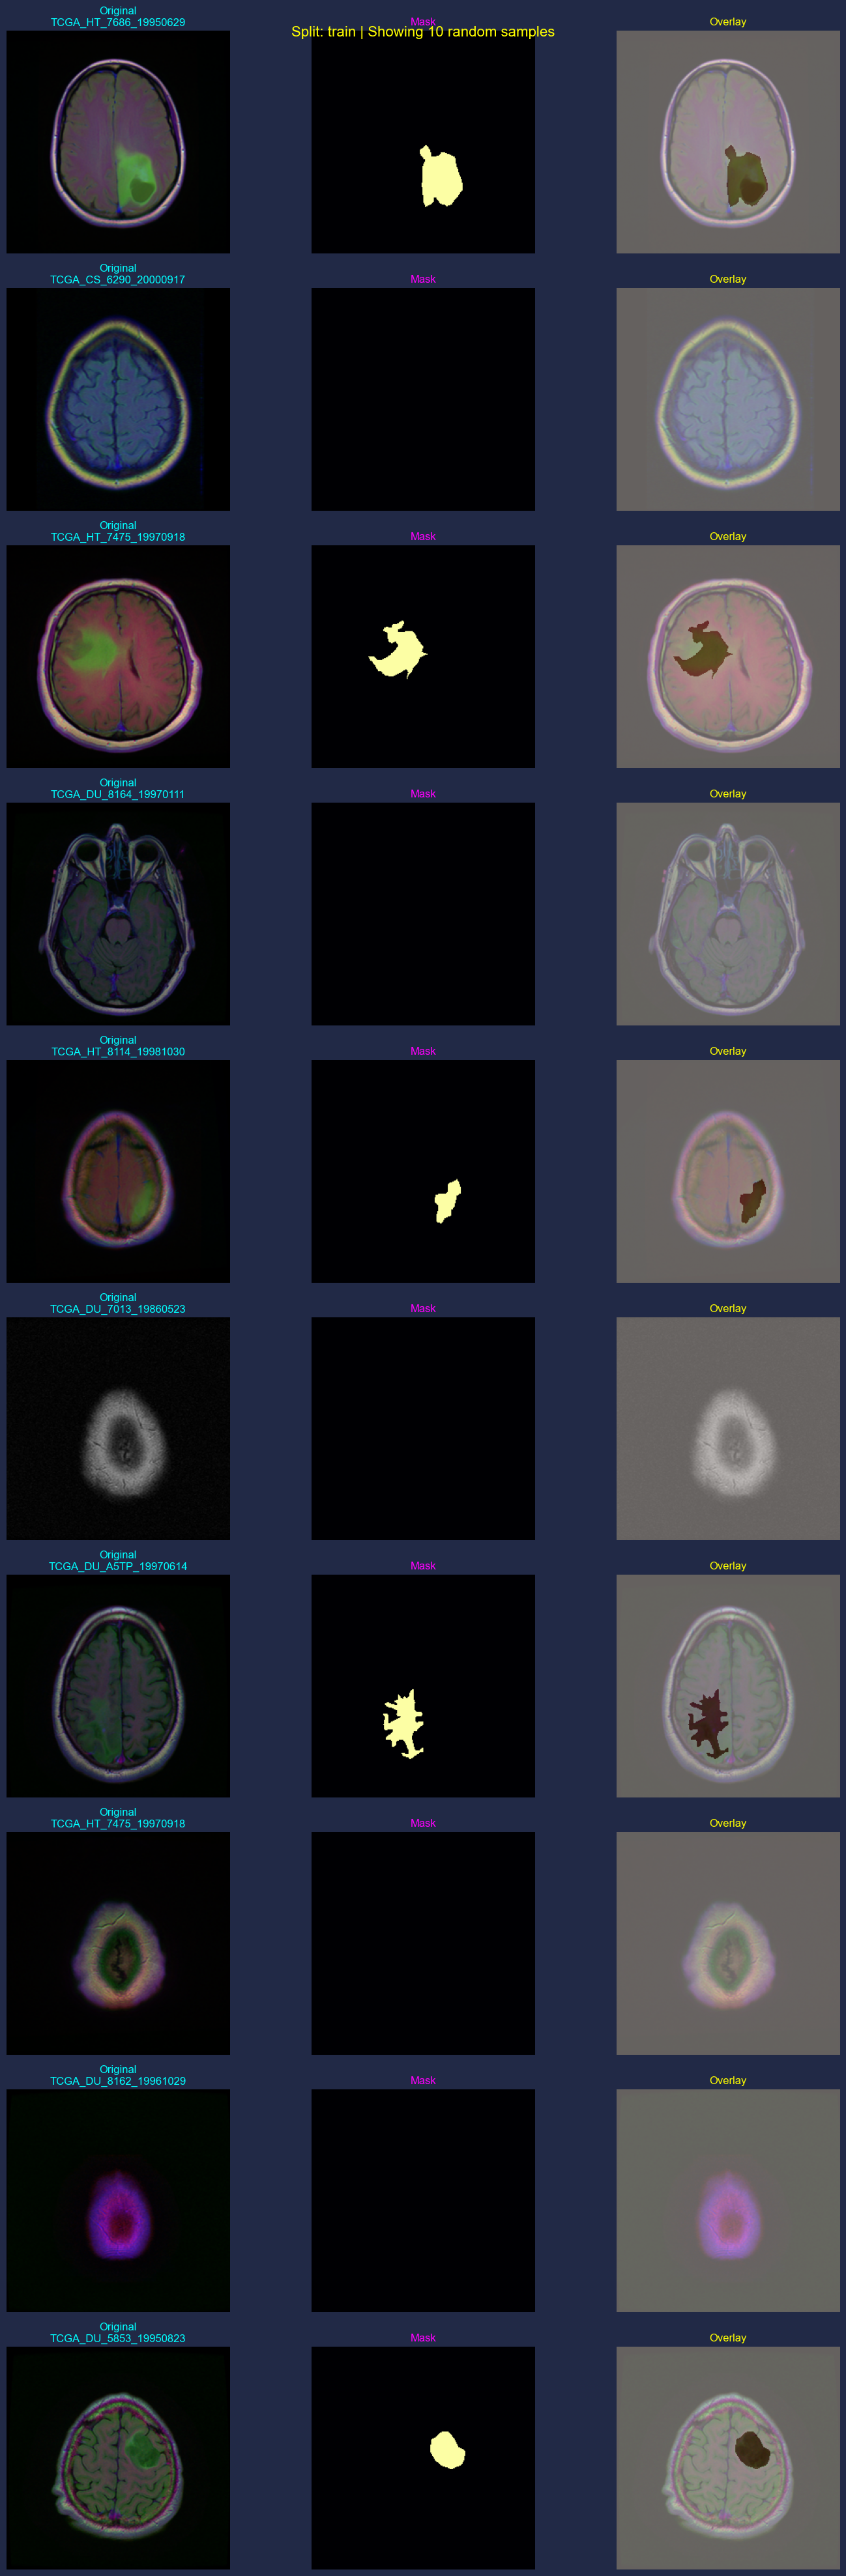

In [8]:

data_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\segmentation\brain_mri"
splits = ["train", "val", "test"]

random_split = random.choice(splits)
print("Split chosen:", random_split)

orig_root = os.path.join(data_dir, random_split, "Original")
segm_root = os.path.join(data_dir, random_split, "Segmented")

num_samples = 10

samples = []
for _ in range(num_samples):
    random_class = random.choice(os.listdir(orig_root))
    img_name = random.choice(os.listdir(os.path.join(orig_root, random_class)))
    samples.append((random_class, img_name))

plt.style.use("cyberpunk")
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))

for i, (random_class, img_name) in enumerate(samples):
    orig_path = os.path.join(orig_root, random_class, img_name)
    name, ext = os.path.splitext(img_name)
    mask_name = name + "_mask" + ext
    segm_path = os.path.join(segm_root, random_class, mask_name)

    orig_img = cv2.imread(orig_path, cv2.IMREAD_UNCHANGED)
    segm_img = cv2.imread(segm_path, cv2.IMREAD_UNCHANGED)

    if orig_img is None or segm_img is None:
        continue
    if orig_img.ndim == 3:
        base = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        gray_base = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    else:
        base = orig_img
        gray_base = orig_img

    if segm_img.ndim == 3:
        mask = cv2.cvtColor(segm_img, cv2.COLOR_BGR2GRAY)
    else:
        mask = segm_img

    # --- Original ---
    axes[i, 0].imshow(base)  
    axes[i, 0].set_title(f"Original\n{random_class}", fontsize=12, color="cyan")
    axes[i, 0].axis("off")

    # --- Mask ---
    axes[i, 1].imshow(mask, cmap="inferno")  
    axes[i, 1].set_title("Mask", fontsize=12, color="magenta")
    axes[i, 1].axis("off")

    # --- Overlay ---
    axes[i, 2].imshow(base)  # RGB background
    axes[i, 2].imshow(mask, cmap="Reds", alpha=0.4)  
    axes[i, 2].set_title("Overlay", fontsize=12, color="yellow")
    axes[i, 2].axis("off")

plt.suptitle(f"Split: {random_split} | Showing {num_samples} random samples",
             fontsize=16, color="yellow")
plt.tight_layout()
plt.show()


In [9]:
# Paths
train_original = os.path.join(data_dir, "train", "Original")
train_segmented = os.path.join(data_dir, "train", "Segmented")

In [10]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    # Continuous IoU
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Continuous Dice
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)



In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

# Patch Embedding Layer
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size=16, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        x = self.projection(x)
        return self.flatten(x)

# Transformer Block
def transformer_block(x, embed_dim, num_heads, mlp_dim):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    mlp = layers.Dense(mlp_dim, activation="relu")(x)
    mlp = layers.Dense(embed_dim)(mlp)
    x = layers.Add()([x, mlp])
    return layers.LayerNormalization()(x)


# 🧩 Vision Transformer U-Net

In [12]:
# ViT-U-Net
def vit_unet(input_size=(128,128,3), num_classes=1, patch_size=16, embed_dim=512,
             num_heads=8, num_layers=12, mlp_dim=1024):
    inputs = Input(shape=input_size)

    # --- Encoder ---
    # Patch embedding
    patch_embed = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)(inputs)

    # Transformer blocks
    x = patch_embed
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, mlp_dim)

    # Reshape transformer output back into 2D
    h = input_size[0] // patch_size
    w = input_size[1] // patch_size
    x = layers.Reshape((h, w, embed_dim))(x)

    # --- Skip connections (like U-Net) ---
    # Early low-level features
    skip1 = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inputs)   # 128x128
    skip1 = layers.MaxPooling2D((2,2))(skip1)                                     # 64x64

    skip2 = layers.Conv2D(128, (3,3), padding="same", activation="relu")(skip1)   # 64x64
    skip2 = layers.MaxPooling2D((2,2))(skip2)                                     # 32x32

    skip3 = layers.Conv2D(256, (3,3), padding="same", activation="relu")(skip2)   # 32x32
    skip3 = layers.MaxPooling2D((2,2))(skip3)                                     # 16x16

    # Now transformer output is (8x8xembed_dim)
    # Decoder with skip connections
    x = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding="same", activation="relu")(x)  # 16x16
    x = layers.Concatenate()([x, skip3])

    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding="same", activation="relu")(x)  # 32x32
    x = layers.Concatenate()([x, skip2])

    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding="same", activation="relu")(x)   # 64x64
    x = layers.Concatenate()([x, skip1])

    x = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding="same", activation="relu")(x)   # 128x128

    
    # --- Output ---
    outputs = layers.Conv2D(num_classes, (1,1), activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    return model


In [13]:
def bce_dice_loss(y_true, y_pred, alpha=0.3, beta=0.7):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1 - dice_coefficient(y_true, y_pred)
    return alpha * bce + beta * dice


In [14]:
model = vit_unet(input_size=(128,128,3), num_classes=1)
model.compile(
    optimizer=Adam(1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", iou_metric, dice_coefficient]
)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patch_embedding (PatchEmbe  (None, 64, 512)              393728    ['input_1[0][0]']             
 dding)                                                                                           
                                                                                                  
 multi_head_attention (Mult  (None, 64, 512)              8401408   ['patch_embedding[0][0]',     
 iHeadAttention)                                                     'patch_embedding[0][0]']     
                                                                                            

In [16]:
model = vit_unet(
    input_size=(128,128,3),
    num_classes=1,
    patch_size=16,
    embed_dim=512,     
    num_heads=8,
    num_layers=12,
    mlp_dim=1024
)


In [17]:
model.compile(
    optimizer=Adam(1e-4),
    loss=bce_dice_loss,   # custom loss
    metrics=["accuracy", iou_metric, dice_coefficient]
)

In [18]:
IMG_SIZE = (128, 128)

class SegmentationDataGenerator(Sequence):
    def __init__(self, image_root, mask_root, batch_size=16):
        self.image_paths = []
        self.mask_paths = []
        self.batch_size = batch_size

        for subfolder in os.listdir(image_root):
            img_dir = os.path.join(image_root, subfolder)
            mask_dir = os.path.join(mask_root, subfolder)

            for fname in os.listdir(img_dir):
                img_path = os.path.join(img_dir, fname)
                name, ext = os.path.splitext(fname)
                mask_path = os.path.join(mask_dir, name + "_mask" + ext)

                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []

        for i in batch_idx:
            img = cv2.imread(self.image_paths[i])
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0

            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
            mask = mask / 255.0
            mask = (mask > 0.5).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            X.append(img)
            y.append(mask)

        return np.array(X), np.array(y)


In [19]:
train_gen = SegmentationDataGenerator(
    image_root=os.path.join(data_dir, "train", "Original"),
    mask_root=os.path.join(data_dir, "train", "Segmented"),
    batch_size=16
)

val_gen = SegmentationDataGenerator(
    image_root=os.path.join(data_dir, "val", "Original"),
    mask_root=os.path.join(data_dir, "val", "Segmented"),
    batch_size=16
)

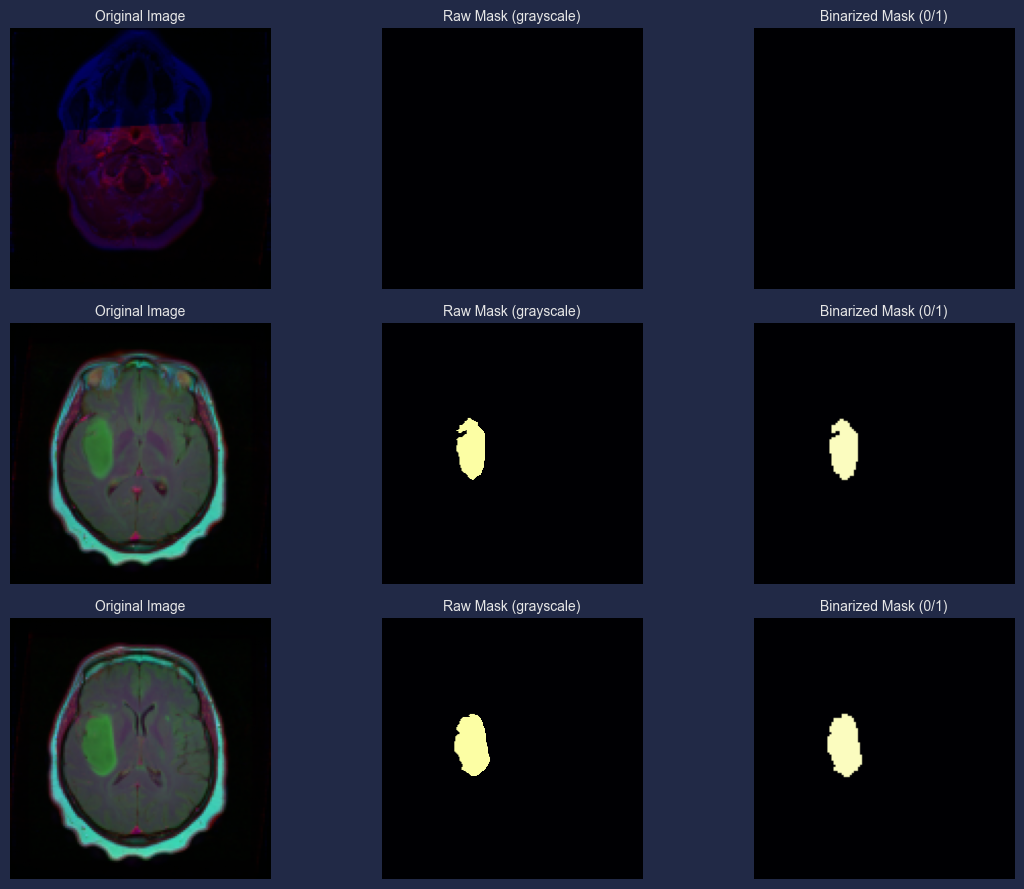

In [20]:
import matplotlib.pyplot as plt
import mplcyberpunk

def visualize_masks_cyberpunk(generator, n=3):
    X, y = generator[0]  # take first batch
    plt.style.use("cyberpunk")

    plt.figure(figsize=(12, n * 3))

    for i in range(n):
        img = X[i]
        raw_mask = cv2.imread(generator.mask_paths[i], cv2.IMREAD_GRAYSCALE)
        bin_mask = (y[i].squeeze() > 0.5).astype(np.float32)

        # Plot Original Image
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original Image", fontsize=10)
        plt.axis("off")

        # Plot Raw Mask
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(raw_mask, cmap="inferno")
        plt.title("Raw Mask (grayscale)", fontsize=10)
        plt.axis("off")

        # Plot Binarized Mask
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(bin_mask, cmap="magma")
        plt.title("Binarized Mask (0/1)", fontsize=10)
        plt.axis("off")

    mplcyberpunk.add_glow_effects()
    plt.tight_layout()
    plt.show()

visualize_masks_cyberpunk(val_gen, n=3)


In [21]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


Epoch 1/20


173/173 [==============================] - 635s 4s/step - loss: 0.7395 - accuracy: 0.9827 - iou_metric: 0.0059 - dice_coefficient: 0.0117 - val_loss: 0.7040 - val_accuracy: 0.9928 - val_iou_metric: 0.0079 - val_dice_coefficient: 0.0156
Epoch 2/20
173/173 [==============================] - 600s 3s/step - loss: 0.6231 - accuracy: 0.9849 - iou_metric: 0.0783 - dice_coefficient: 0.1304 - val_loss: 0.6031 - val_accuracy: 0.9864 - val_iou_metric: 0.0952 - val_dice_coefficient: 0.1517
Epoch 3/20
173/173 [==============================] - 618s 4s/step - loss: 0.5543 - accuracy: 0.9785 - iou_metric: 0.1565 - dice_coefficient: 0.2339 - val_loss: 0.6211 - val_accuracy: 0.9466 - val_iou_metric: 0.1024 - val_dice_coefficient: 0.1603
Epoch 4/20
173/173 [==============================] - 598s 3s/step - loss: 0.5184 - accuracy: 0.9862 - iou_metric: 0.2050 - dice_coefficient: 0.2846 - val_loss: 0.5591 - val_accuracy: 0.9858 - val_iou_metric: 0.1573 - val_dice_coefficient: 0.2203
Epoch 5/20

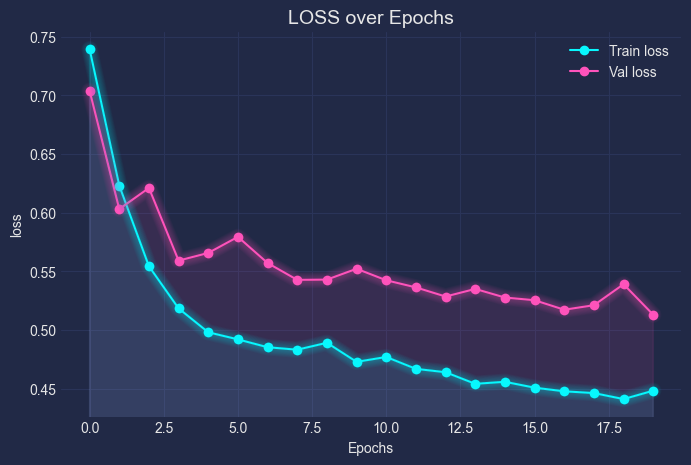

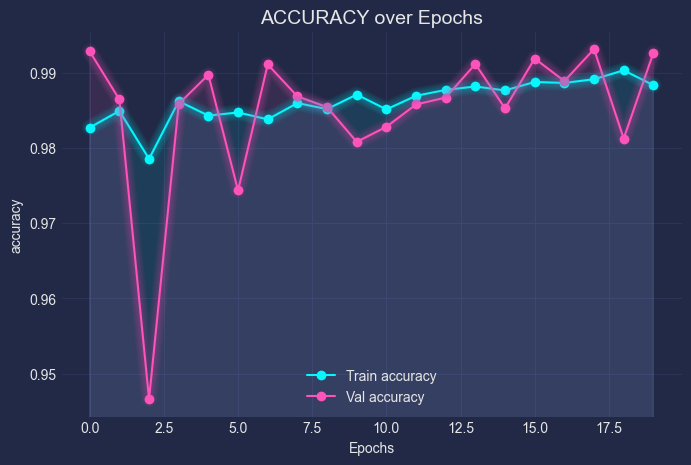

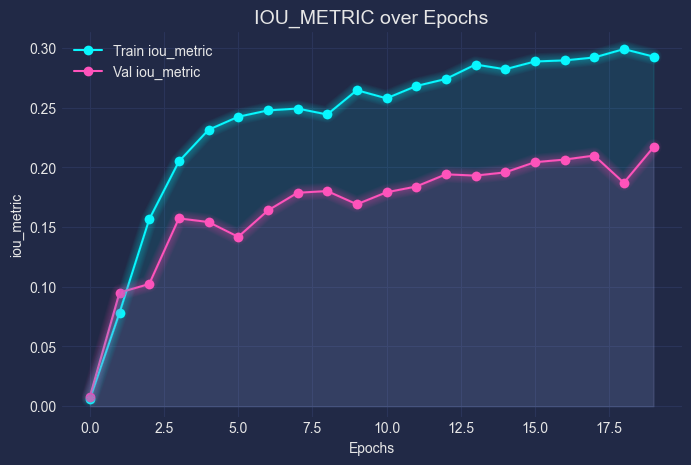

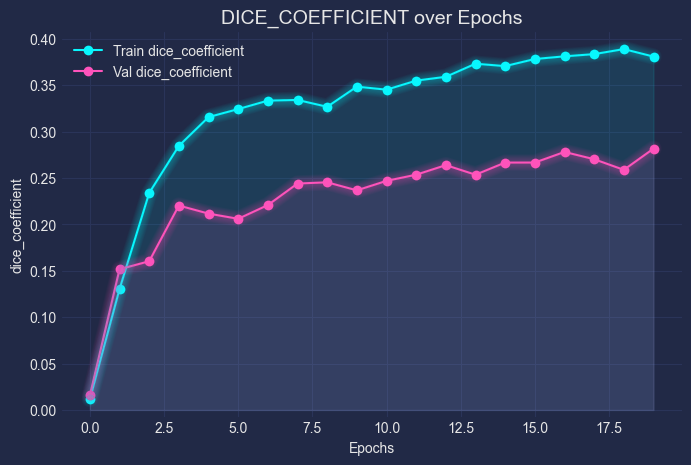

In [22]:
import matplotlib.pyplot as plt
import mplcyberpunk

def plot_training(history):
    plt.style.use("cyberpunk")
    metrics = ["loss", "accuracy", "iou_metric", "dice_coefficient"]

    for metric in metrics:
        plt.figure(figsize=(8,5))
        plt.plot(history.history[metric], label=f"Train {metric}", marker="o")
        plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}", marker="o")
        plt.title(f"{metric.upper()} over Epochs", fontsize=14)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        mplcyberpunk.add_glow_effects()
        plt.show()

plot_training(history)


In [23]:
test_gen = SegmentationDataGenerator(
    image_root=os.path.join(data_dir, "test", "Original"),
    mask_root=os.path.join(data_dir, "test", "Segmented"),
    batch_size=16
)

results = model.evaluate(test_gen)
print("📊 Test Results:", dict(zip(model.metrics_names, results)))


33/33 [==============================] - 30s 919ms/step - loss: 0.4490 - accuracy: 0.9898 - iou_metric: 0.2857 - dice_coefficient: 0.3800
📊 Test Results: {'loss': 0.4489839971065521, 'accuracy': 0.9897913932800293, 'iou_metric': 0.28569039702415466, 'dice_coefficient': 0.37997180223464966}


1/1 [==============================] - 3s 3s/step


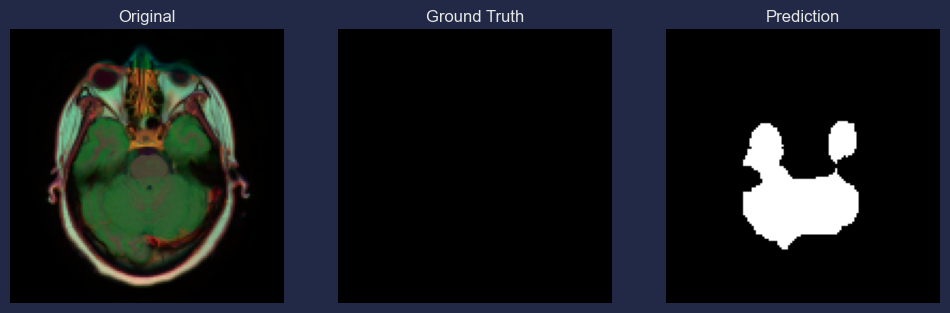

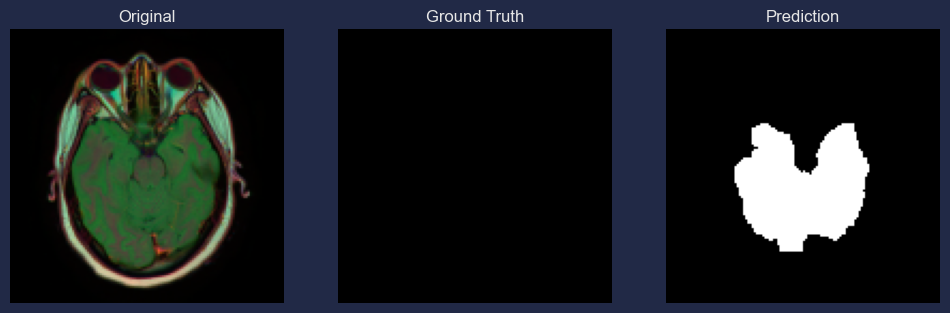

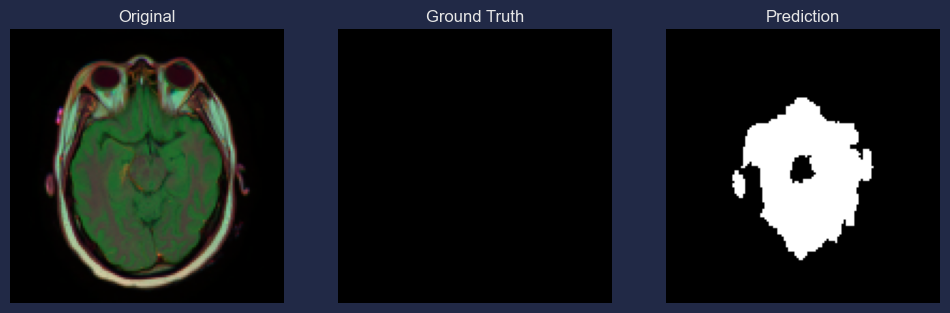

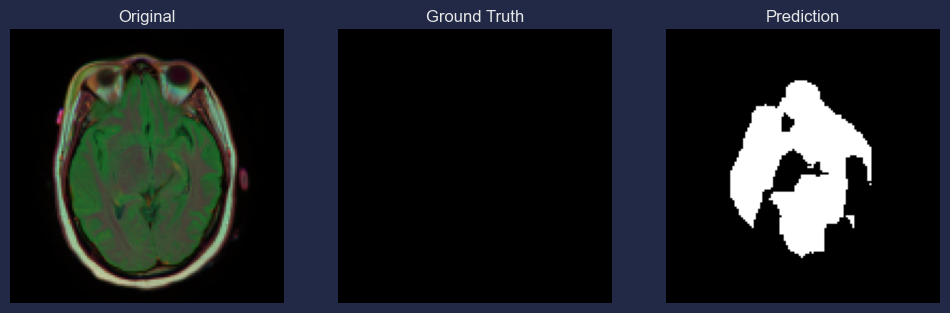

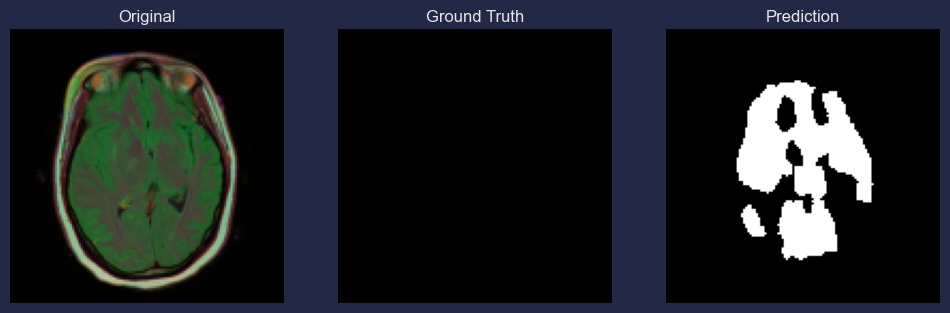

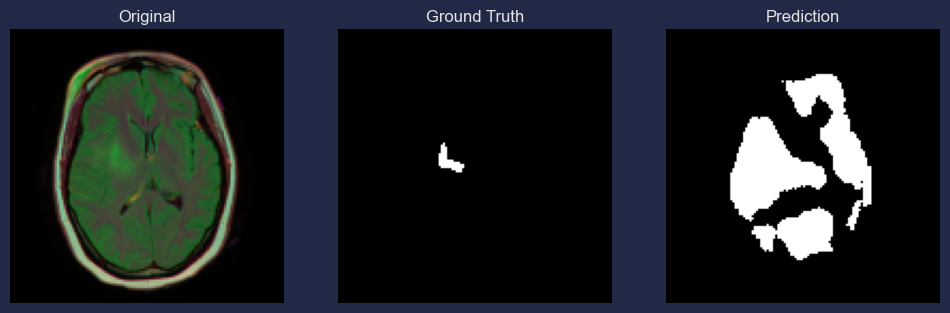

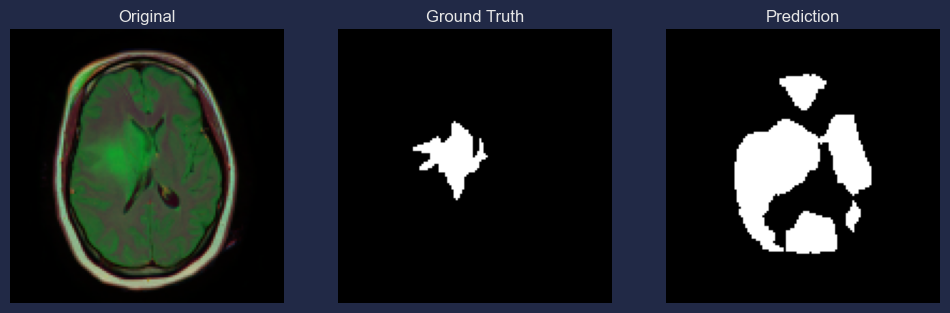

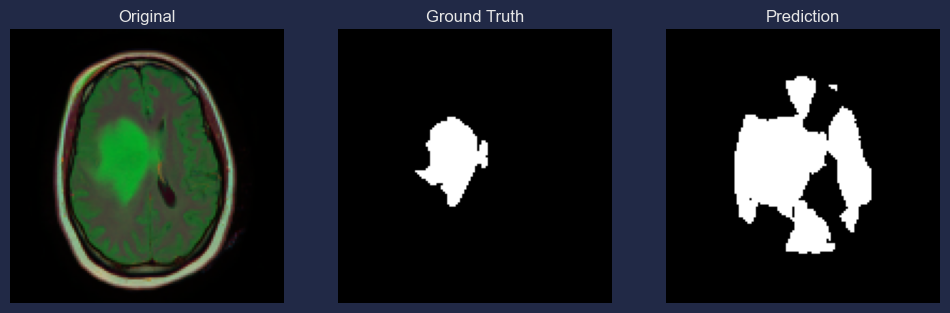

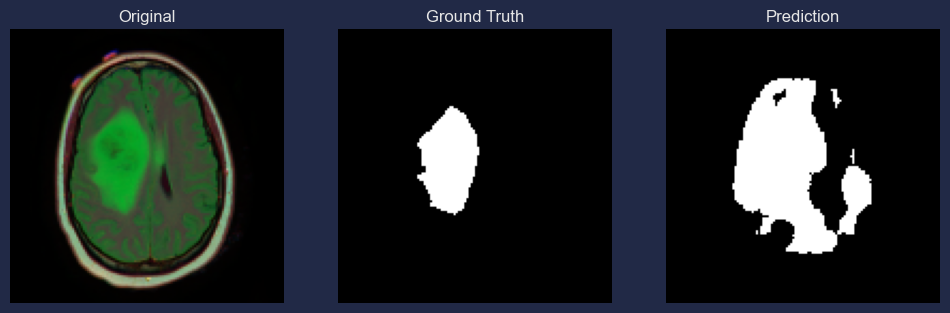

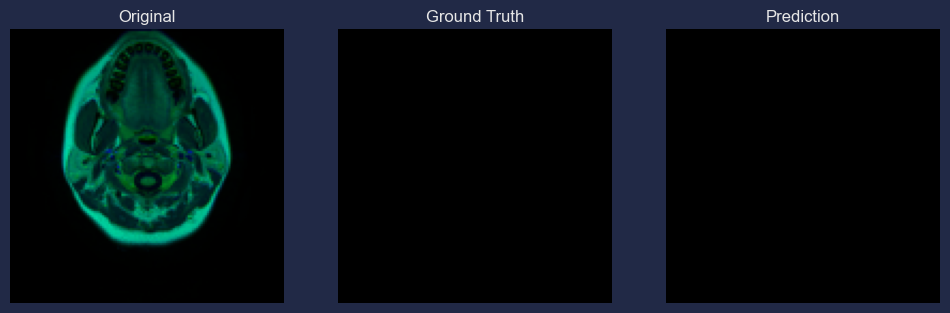

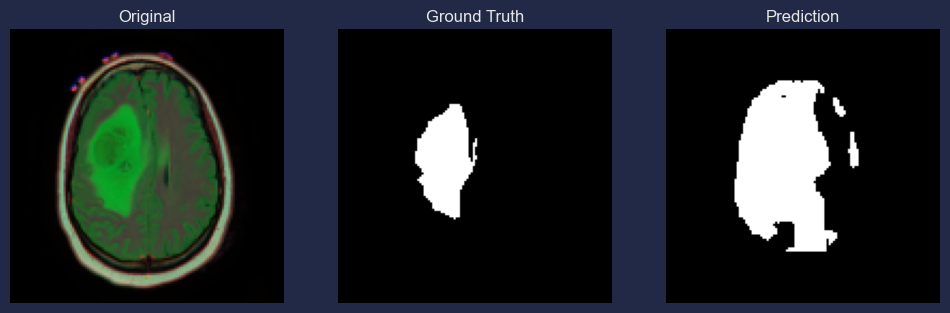

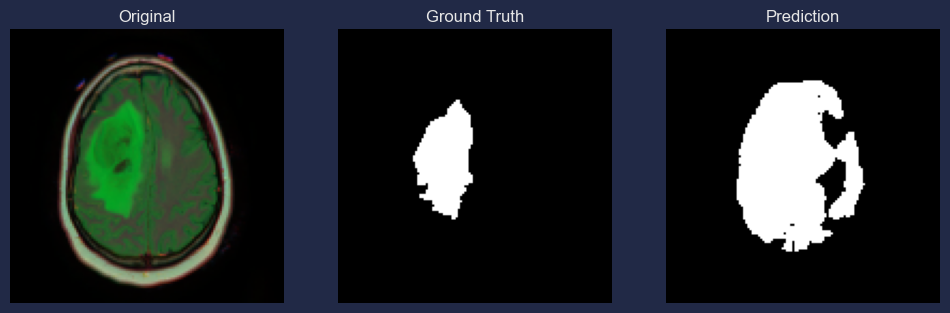

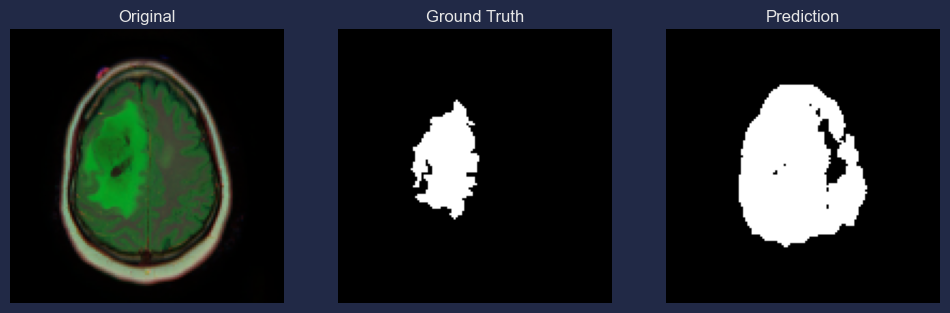

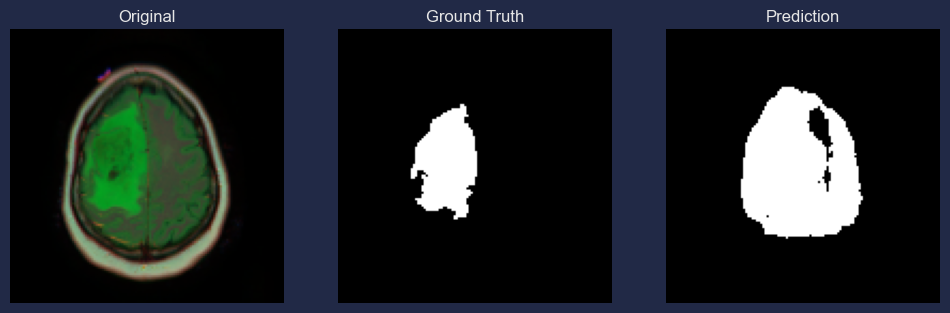

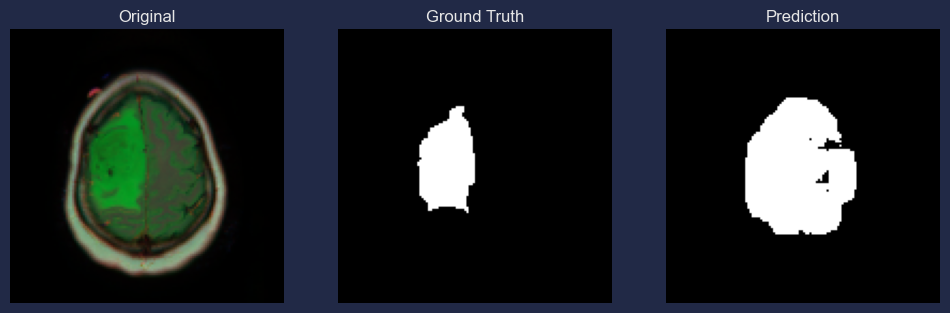

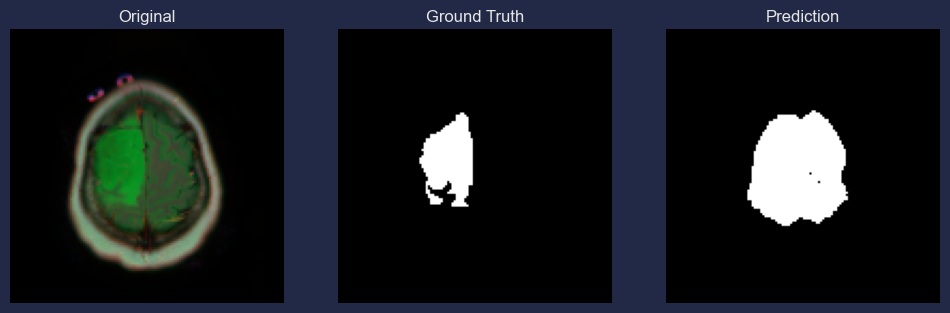

1/1 [==============================] - 1s 894ms/step


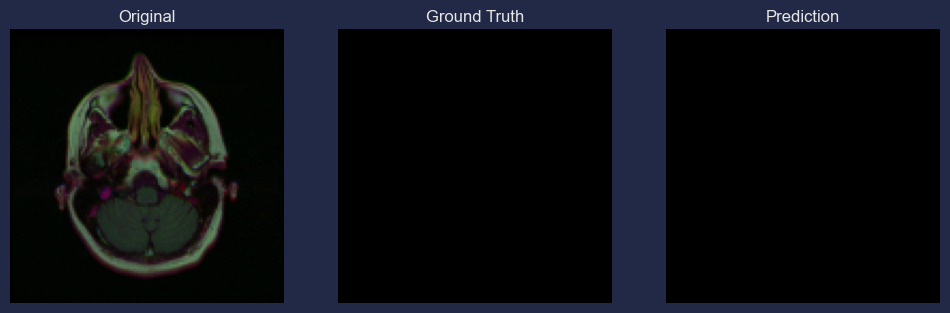

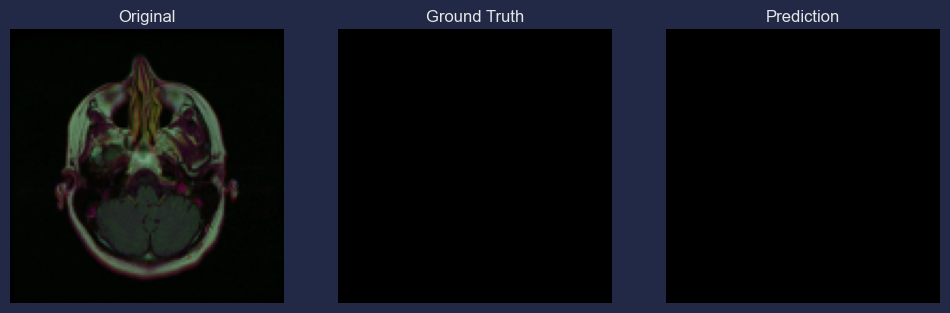

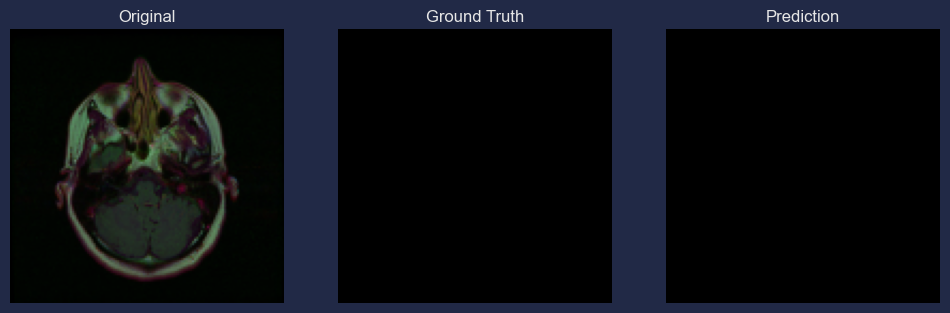

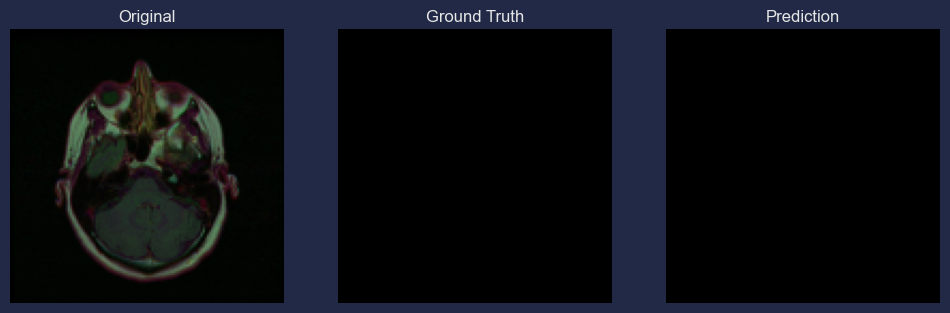

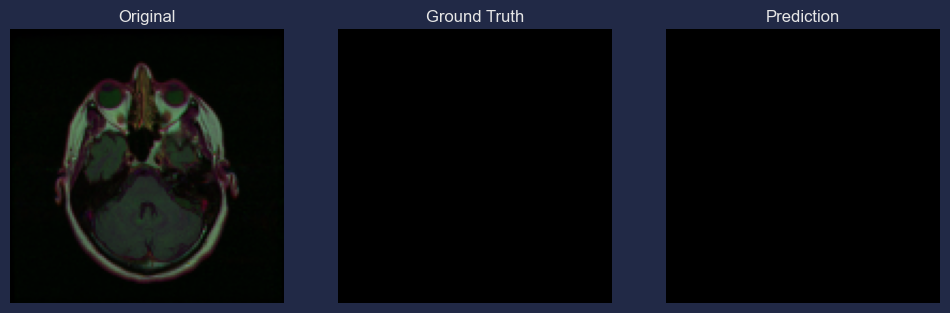

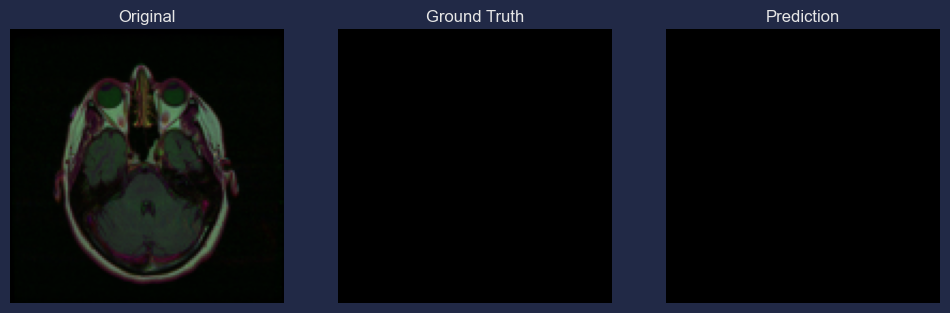

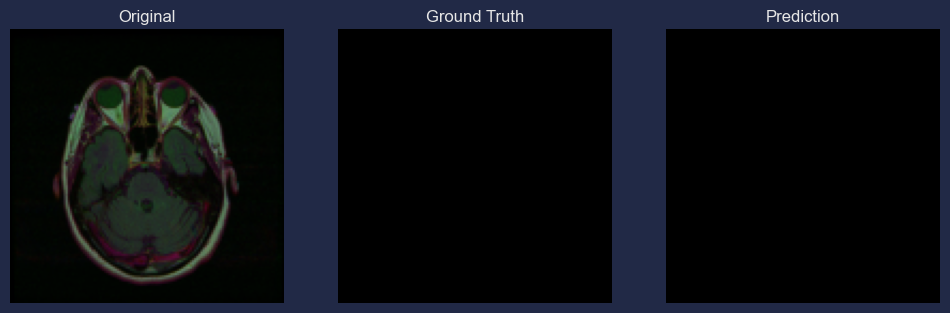

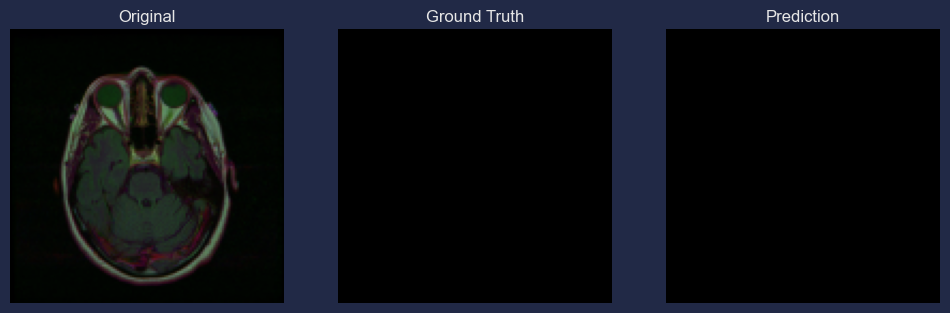

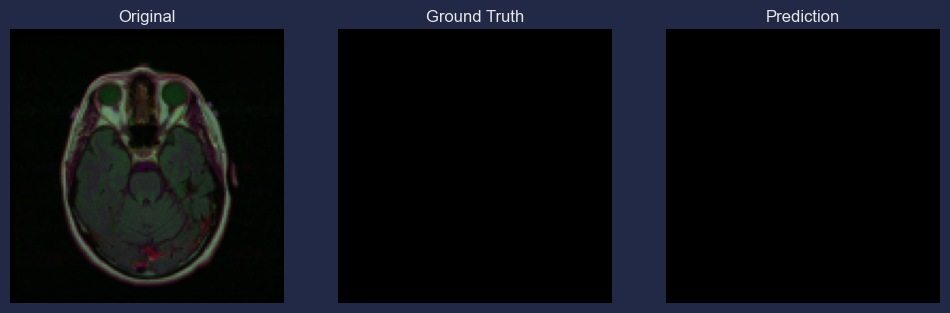

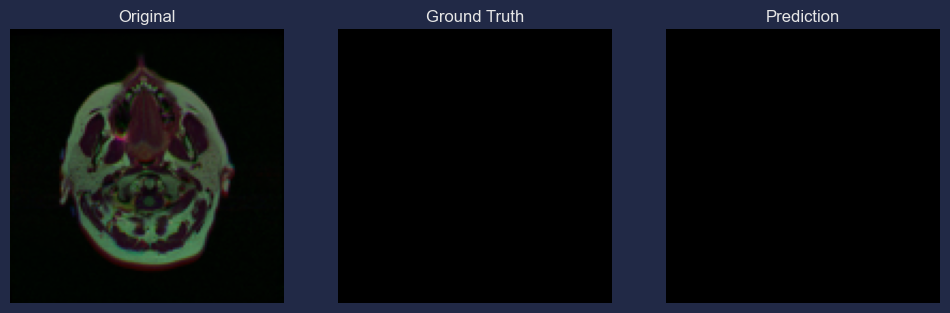

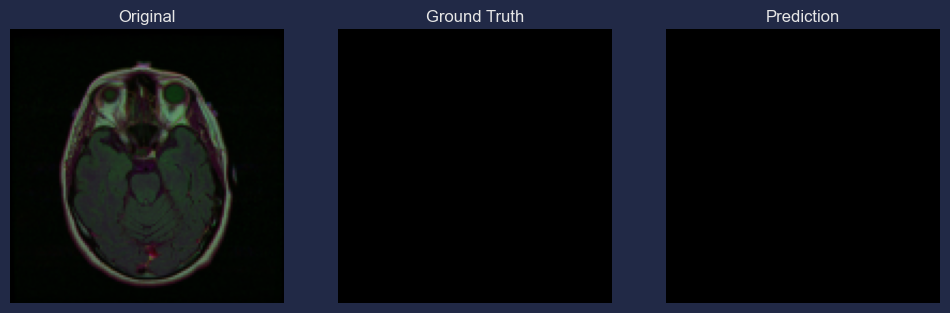

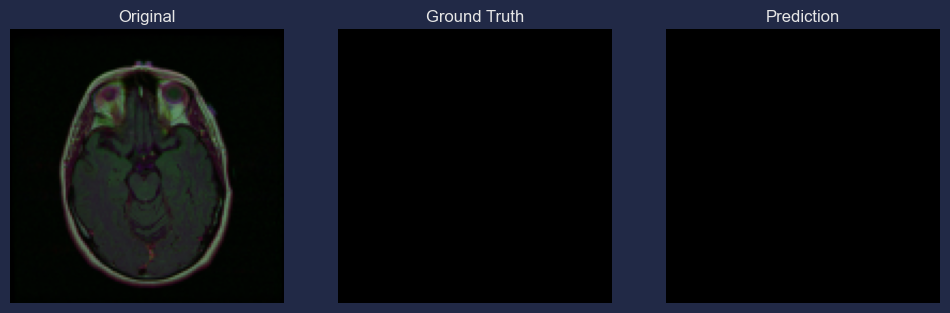

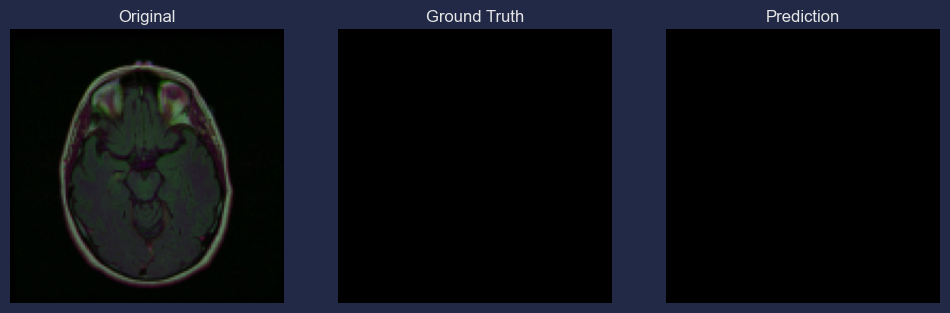

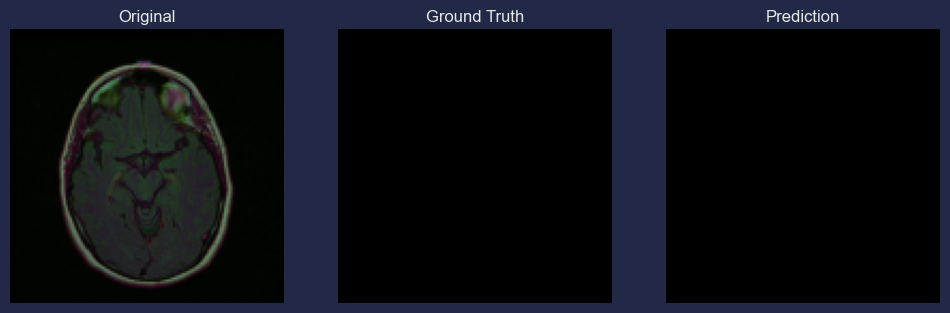

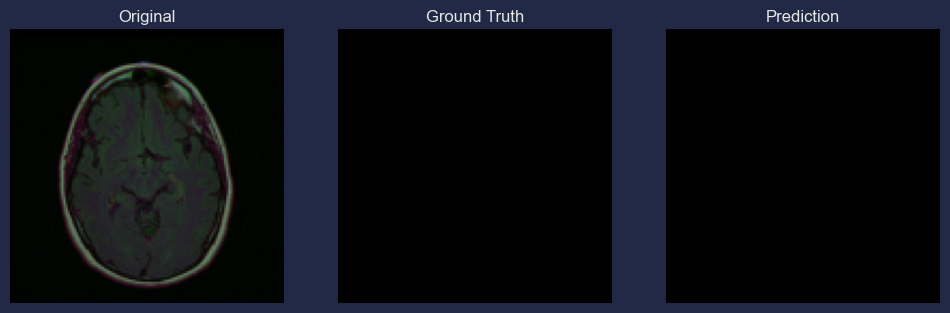

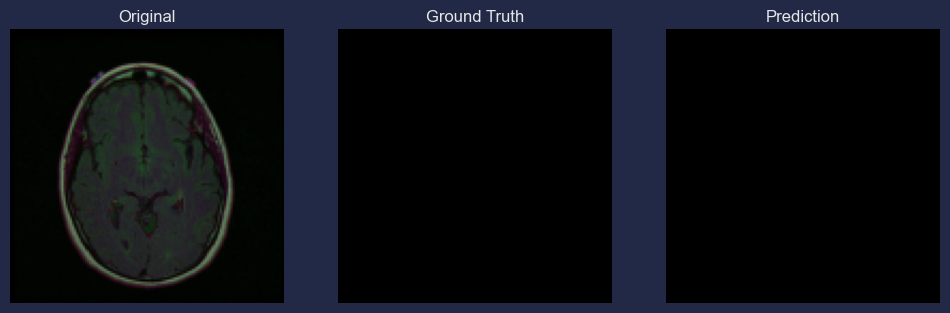

1/1 [==============================] - 1s 982ms/step


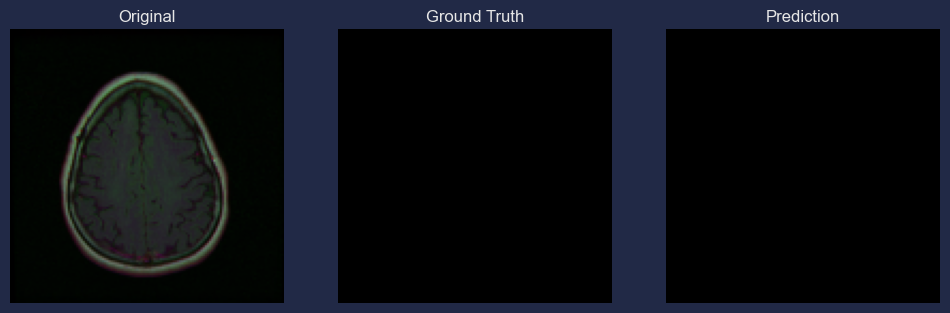

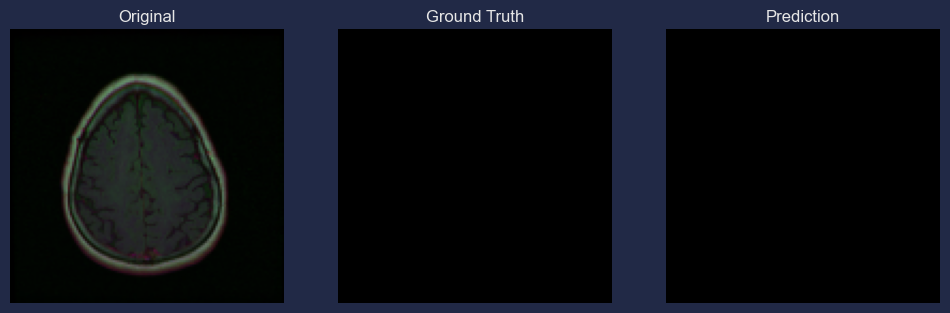

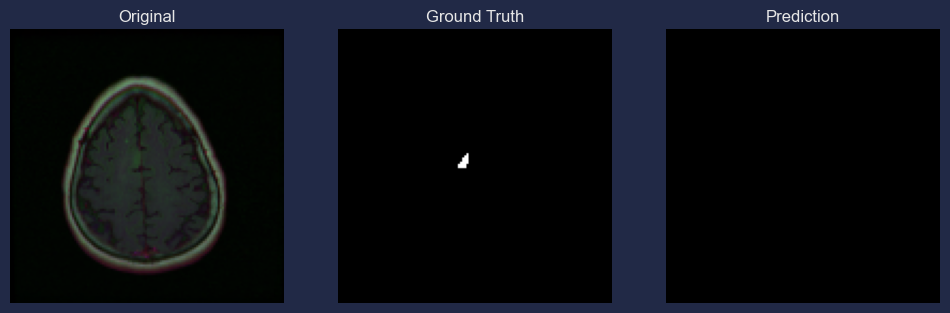

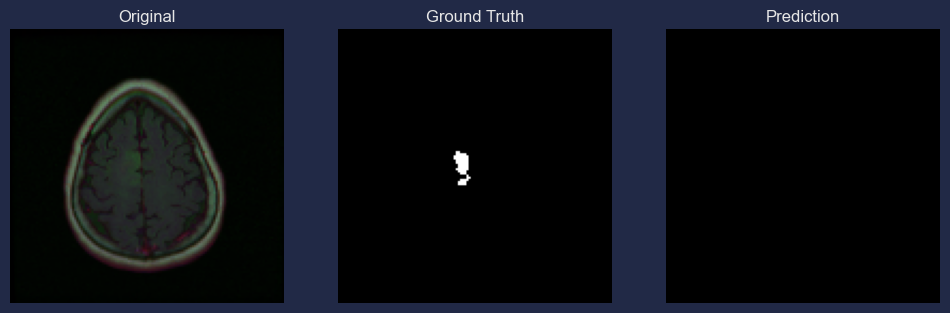

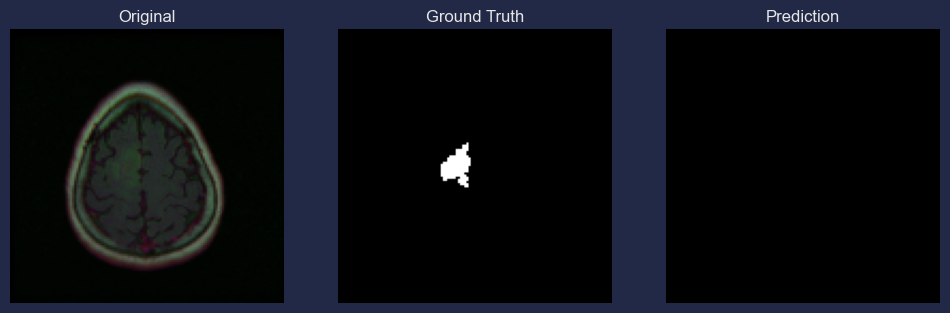

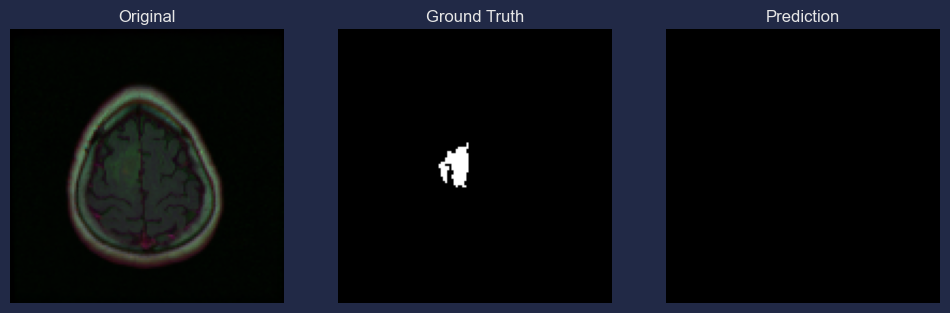

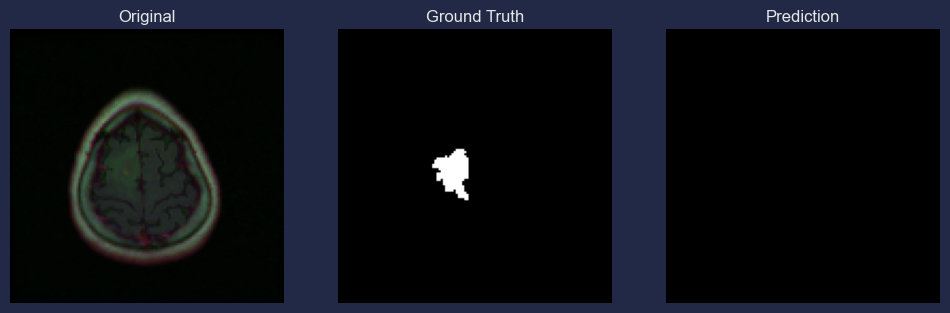

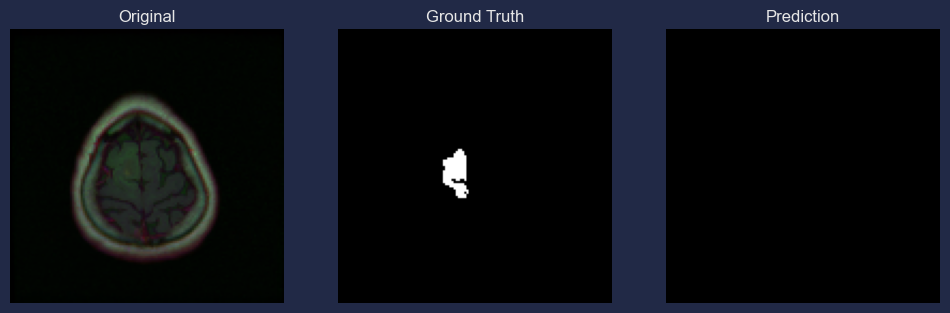

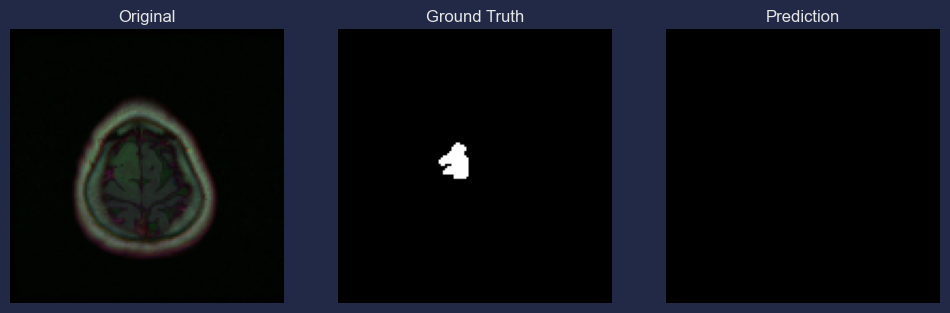

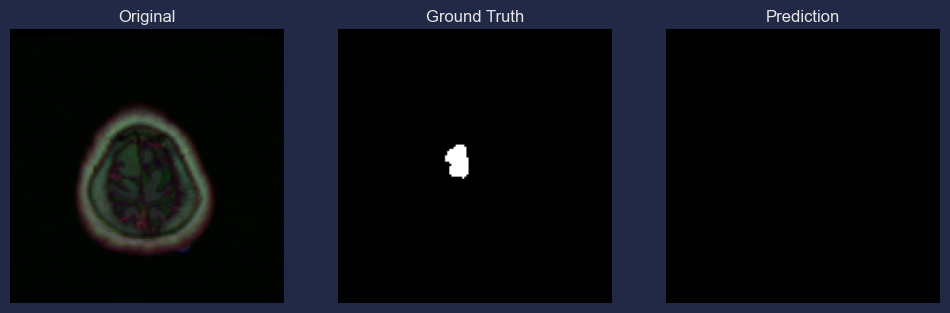

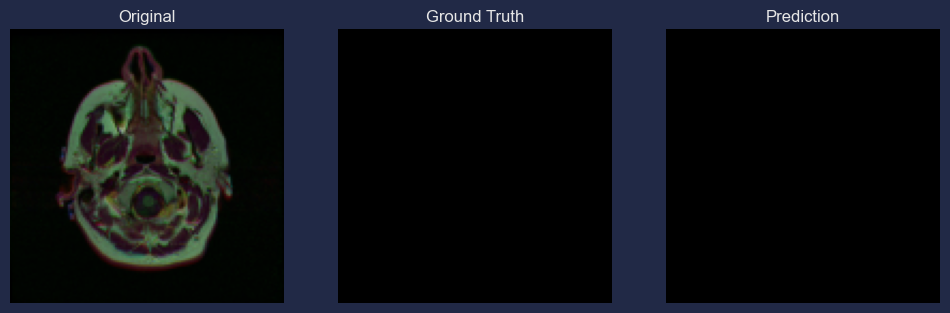

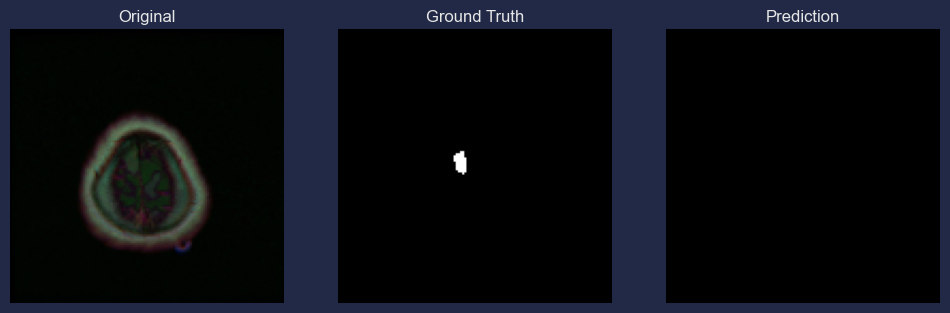

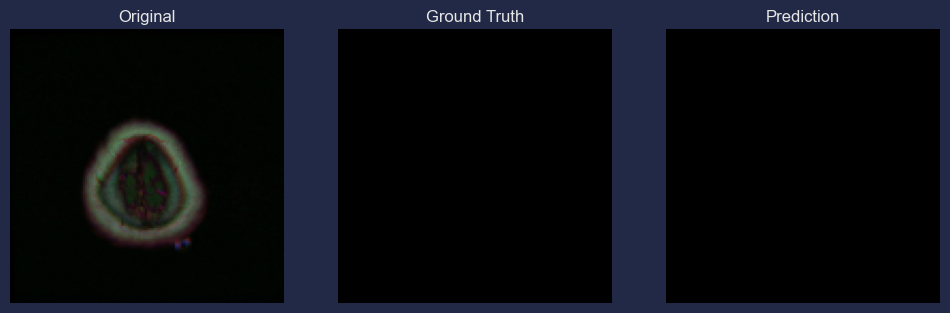

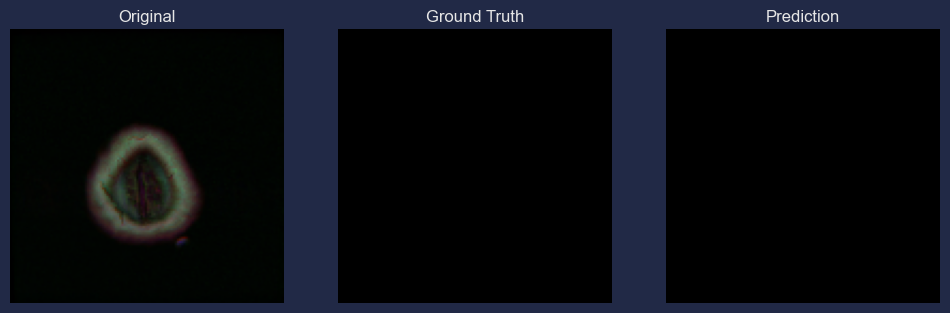

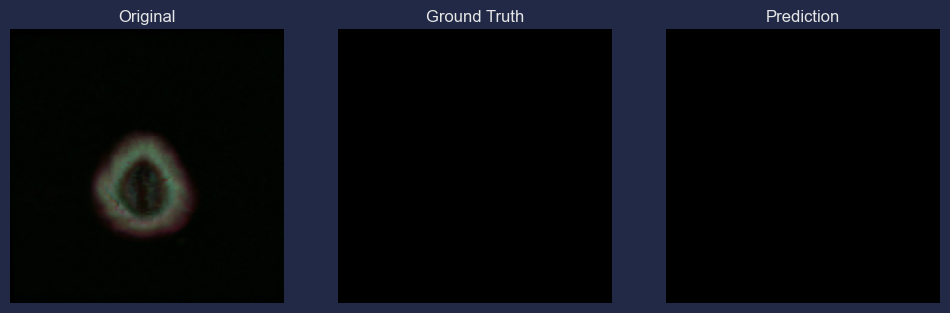

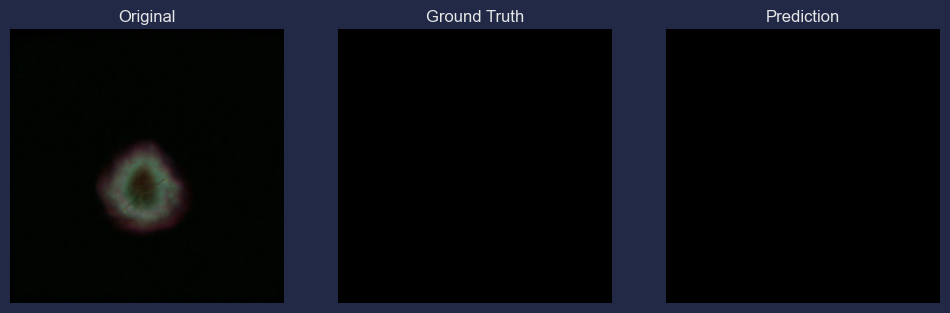

In [24]:
import random

def visualize_predictions(model, generator, num_samples=3):
    idxs = random.sample(range(len(generator)), num_samples)

    for idx in idxs:
        X, y_true = generator[idx]
        y_pred = model.predict(X)

        for i in range(len(X)):
            plt.figure(figsize=(12,4))

            # Original
            plt.subplot(1,3,1)
            plt.imshow(X[i])
            plt.title("Original")
            plt.axis("off")

            # Ground Truth
            plt.subplot(1,3,2)
            plt.imshow(y_true[i].squeeze(), cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            # Prediction
            plt.subplot(1,3,3)
            plt.imshow(y_pred[i].squeeze() > 0.5, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()


visualize_predictions(model, test_gen)

In [25]:
import json

with open("seg_mri_vit_history.json", "w") as f:
    json.dump(history.history, f)



In [26]:
import pandas as pd
import os


ckpt_dir = r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\segmentation"
os.makedirs(ckpt_dir, exist_ok=True)

history_df = pd.DataFrame(history.history)
csv_path = os.path.join(ckpt_dir, "seg_mri_vit_history.csv")
history_df.to_csv(csv_path, index=False)

print(f"✅ Training history saved at {csv_path}")


✅ Training history saved at C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\segmentation\seg_mri_vit_history.csv


In [30]:
# Save weights
weights_path = os.path.join(ckpt_dir, "vit_mri_model.pt")
model.save_weights(weights_path)

print(f"✅ Model weights saved at {weights_path}")


✅ Model weights saved at C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\segmentation\vit_mri_model.pt


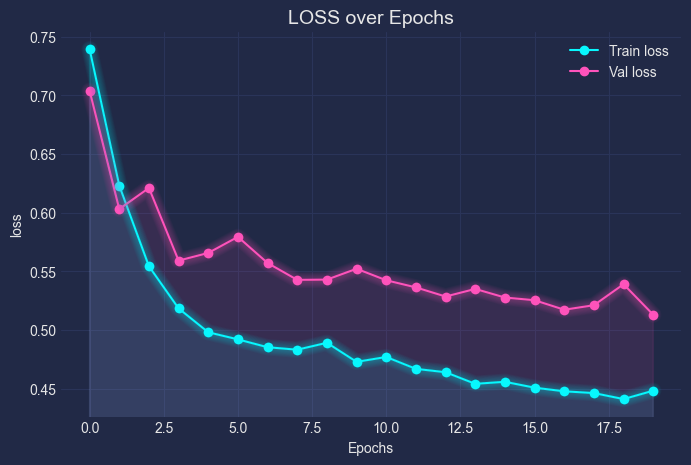

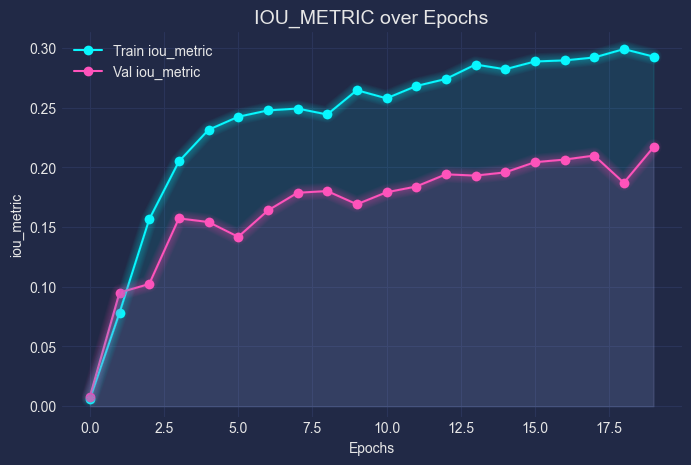

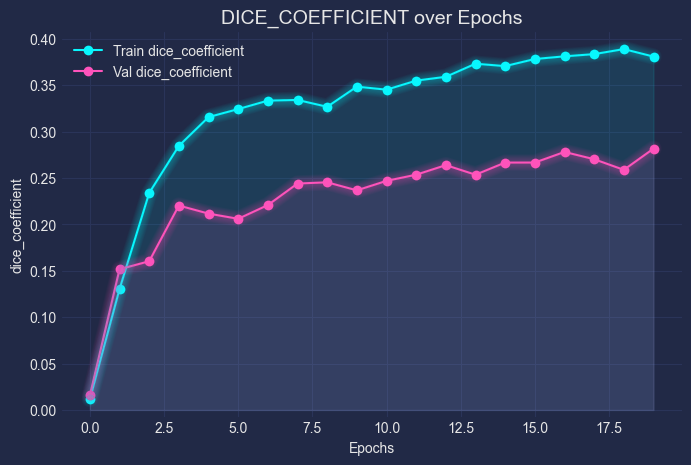

In [28]:
import matplotlib.pyplot as plt
import mplcyberpunk

def plot_from_csv(csv_path):
    history_df = pd.read_csv(csv_path)
    plt.style.use("cyberpunk")

    for metric in ["loss", "iou_metric", "dice_coefficient"]:
        plt.figure(figsize=(8,5))
        plt.plot(history_df[metric], label=f"Train {metric}", marker="o")
        plt.plot(history_df[f"val_{metric}"], label=f"Val {metric}", marker="o")
        plt.title(f"{metric.upper()} over Epochs", fontsize=14)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        mplcyberpunk.add_glow_effects()
        plt.show()

# Example usage
plot_from_csv(csv_path)


In [29]:
model.save_weights("seg_mri_vit_model.h5")